## Industrial green fuel demand
1. Loading of all packages and functions
2. Per subsector (Steel, Basic Chemicals, NMM)
3. 

### Packages

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from osgeo import ogr

import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

### Input Variables

In [102]:
save_final_result = False

In [103]:
jrc_region = 'AT'
#['EU27', 'AT', 'BE', 'BG', 'CY', 
# 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 
# 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 
# 'PT', 'RO', 'SE', 'SI', 'SK']

gdp_region = 'Austria'
#['European Union - 27 countries (from 2020)', 'Austria','Belgium', 'Bulgaria', 'Cyprus', 
# 'Czechia','Germany', 'Denmark', 'Estonia', 'Greece', 'Spain','Finland', 'France', 'Croatia', 
# 'Hungary', 'Ireland', 'Italy', 'Lithuania','Luxembourg', 'Latvia', 'Malta','Netherlands', 'Poland',
# 'Portugal', 'Romania', 'Sweden',  'Slovenia', 'Slovakia']

In [104]:
targets_steel_bf = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}


In [105]:
targets_cement = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}

In [106]:
targets_ceramics = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}

In [107]:
targets_glass = {
    2020: 0.00,
    2030: 0.10,
    2040: 0.40,
    2050: 1.00
}

### Functions

In [108]:

def linear_regression_single_sector(demand_df, sector_name, historic_gdp, projected_gdp, gdp, region, unit, plot=False, save=False):
    """
    Perform linear regression on a single-sector demand dataset and optionally plot/save results.

    Parameters:
    - demand_df: DataFrame with Year as index and one column with demand data.
    - sector_name: Name of the sector (string) to label outputs.
    - historic_gdp: DataFrame of historical GDP data (matching time index).
    - projected_gdp: DataFrame of future GDP data (matching time index).
    - gdp: Full GDP data for plotting (includes past + future).
    - region: Name of the region (string) for GDP plotting.
    - unit: String unit label for demand.
    - plot: Boolean to show a plot of historical and predicted demand.
    - save: Boolean to save the results as an Excel file.

    Returns:
    - results: DataFrame with predicted future demand indexed by year.
    """

    # Merge demand and GDP data for modeling
    historical_data = demand_df.join(historic_gdp)

    # Standardize historical GDP for PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(historic_gdp)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(data_scaled)

    # Add principal component to dataset
    historical_data['PC1'] = principal_components

    # Define feature matrix X and target y
    y = historical_data[demand_df.columns[0]]  # demand
    X = historical_data[['PC1']]               # first principal component of GDP

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Transform future GDP data using the same scaler and PCA
    future_data_scaled = scaler.transform(projected_gdp)
    future_pc1 = pca.transform(future_data_scaled)
    future_pc1_df = pd.DataFrame(future_pc1, index=projected_gdp.index, columns=['PC1'])

    # Predict future demand
    y_future = model.predict(future_pc1_df)
    y_future = np.maximum(y_future, 0)  # Ensure demand is non-negative

    # Assemble prediction DataFrame
    results = pd.DataFrame({'Predicted Demand': y_future}, index=projected_gdp.index)

    # Optional plot
    if plot:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot historical and predicted demand
        ax1.plot(demand_df.index, y, label='Historical Demand', color='darkblue')
        ax1.plot(results.index, results['Predicted Demand'], label='Projected Demand (2022–2050)', linestyle='--', color='blue')
        ax1.set_xlabel('Year')
        ax1.set_ylabel(f'Demand in {unit}')
        ax1.legend(loc='upper left')

        # Plot GDP on a secondary axis (in millions)
        ax2 = ax1.twinx()
        ax2.plot(gdp.index, gdp[region] / 1_000_000, label='GDP', color='green')
        ax2.plot(projected_gdp.index, projected_gdp[region] / 1_000_000, label='Projected GDP', linestyle='--', color='lightgreen')
        ax2.set_ylabel('GDP (in million EUR)')
        ax2.legend(loc='upper right')

        plt.title(f'Demand Projection for {sector_name} in {region}')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Optional save
    if save:
        file_path = f"Scripts/Results/{datetime.datetime.today():%Y_%m_%d}_{sector_name.replace(' ', '_')}_{region}.xlsx"
        results.to_excel(file_path)

    return results


In [109]:
def apply_linear_target(demand_df, column_name_all, column_name_after, targets):
    """
    Linearly interpolate a percentage share over time and apply to demand data.

    Parameters:
    - demand_df: pd.DataFrame with datetime-like index, production volume per year.
    - column_name_all: str, name of the column with total demand.
    - column_name_after: str, name of the new column for adjusted demand.
    - targets: dict, keys are years (as int) and values are target percentages (as float, e.g., 0.1 for 10%).

    Returns:
    - pd.DataFrame with an additional column for adjusted demand based on interpolated shares.
    """

    # Create a Series for the target percentages
    target_years = pd.Series(targets)
    target_years.index = pd.to_datetime(target_years.index, format='%Y')
    target_years = target_years.sort_index()

    # Create a full year range between start and end
    full_index = demand_df.index

    # Interpolate linearly and fill missing values
    interpolated_share = (
        target_years.reindex(full_index)
        .interpolate(method='time')
        .ffill()
        .fillna(0)
    )

    # Apply the interpolated share to the demand
    demand_df[column_name_after] = demand_df[column_name_all] * interpolated_share

    return demand_df


In [110]:
def transpose_uniformly(df):
    df_T = df.transpose()
    df_T.columns = df_T.iloc[0]
    df_T.drop([NMM_column_name, "Code"], axis=0, inplace = True)
    df_T.index.name = 'Year'
    df_T.index= pd.to_datetime(df_T.index, format='%Y')
    return(df_T)

In [111]:
def linear_regression_share_prediction(demand_sector_df, future_data_df, column_name_LR, column_name_IV, column_name_IV_future,  graph_title, save=False):
    """
    Perform a simple linear regression on historical data, visualize results, and predict future values.
    
    Parameters:
    - demand_sector_df: DataFrame containing historical demand data.
    - future_data_df: DataFrame containing future values of the independent variable for prediction.
    - column_name_LR: Name of the column in demand_sector_df to be used as the target variable (y).
    - column_name_IV: Name of the column in demand_sector_df and future_data_df to be used as the independent variable (X).
    - save: Boolean indicating whether to save the results to an Excel file.
    
    Returns:
    - A DataFrame containing historical and future predictions.
    """

    # Define the target (y) and feature (X) for historical data
    y = demand_sector_df[column_name_LR]  # Convert y to a Series
    X = demand_sector_df[[column_name_IV]]  # Independent variable (e.g., GDP)

    # Drop NaN values to avoid regression errors
    X = X.dropna()
    y = y.loc[X.index]

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict historical values
    y_pred = model.predict(X)

    # Combine predictions and actual values into a results DataFrame
    results_historical = pd.DataFrame({
        'Actual Percentage': y,
        'Predicted Percentage': y_pred
    }, index=X.index)

    # Prepare future data for prediction
    future_data_df = future_data_df.rename(columns={column_name_IV_future: column_name_IV})
    X_future = future_data_df[[column_name_IV]].dropna()  # Independent variable for future data
    y_future_pred = model.predict(X_future)

    # Combine future predictions into a results DataFrame
    results_future = pd.DataFrame({
        'Predicted Percentage': y_future_pred
    }, index=X_future.index)

    # Combine historical and future results
    combined_results = pd.concat([results_historical[['Predicted Percentage']], results_future], axis=0)

    # Plot historical actual vs. predicted values and future predictions
    plt.figure(figsize=(10, 6))
    plt.plot(results_historical.index, results_historical['Actual Percentage'], label='Actual Percentage (Historical)', color='blue')
    plt.plot(results_historical.index, results_historical['Predicted Percentage'], label='Predicted Percentage (Historical)', color='orange', linestyle='--')
    plt.plot(results_future.index, results_future['Predicted Percentage'], label='Predicted Percentage (Future)', color='green', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel(f'{column_name_LR}')
    plt.title(graph_title)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save results to Excel if requested
    if save:
        combined_results.to_excel(f"results_{column_name_LR}_demand_with_predictions.xlsx")
    
    return combined_results


### Load gdp data projections 

In [112]:
inputs_dir = os.path.join('..', '..','Inputs')
file_name = os.path.join(inputs_dir, 'JRC_DATA','JRC-IDEES-2021', jrc_region, f'JRC-IDEES-2021_Industry_{jrc_region}.xlsx')

gdp_path = os.path.join(inputs_dir, 'Projected_GDP.xlsx') 
gdp = pd.read_excel(gdp_path, index_col="Year")
gdp.index= pd.to_datetime(gdp.index, format='%Y')
gdp = gdp[[gdp_region]]
historic_gdp = gdp[gdp.index < '2022-01-01']
projected_gdp = gdp[gdp.index > '2021-01-01']


## Demand Projections

#### Melting and Casting of Iron and Steel, Aluminium Production, Non-Ferrous Metals

According to UBA (Umweltbundesamt), these processes are already at **TRL 9** for electrification.  
As a result, **full electrification is assumed** for melting, casting, and related metallurgical operations.

---

#### Steam Production

Electrification of steam generation is technically mature, with **electrical alternatives at TRL 9**.  
Available technologies include:
- **Electrode boilers**
- **High-temperature heat pumps**
- **Electric resistance heating systems**

These systems are considered viable substitutes for fossil-based steam generation in industrial contexts.

---

#### Metal Processing in Machinery and Transport Equipment

This category is **already predominantly electrified**.  
Remaining fossil-based energy use is minimal and could be substituted with **green fuels** if necessary,  
though the overall impact is considered **relatively small** in the broader decarbonization strategy.


### Steel Sector: Demand Estimation and Hydrogen Integration

This sector models hydrogen demand in the steel industry by differentiating between the two primary production routes: **Electric Arc Furnace (EAF)** and **Blast Furnace–Basic Oxygen Furnace (BF-BOF)**, with a focus on the transition to **Direct Reduced Iron (DRI)** using hydrogen.

---

####  Calculation Steps and Modeling Logic

1. **Estimate steel production activity** until 2050, with separate projections for EAF and BF/DRI routes.
2. **Quantify hydrogen demand** for the DRI-BF route based on specific energy consumption (SEC) and process assumptions from Neuwirth et al.
3. **Simulate hydrogen adoption** based on a stepwise integration aligned with European decarbonization targets.

---

#### Input Assumptions

##### Electric Arc Furnace (EAF)

- Assumes **no hydrogen demand**.
- Production relies entirely on **electricity and steel scrap recycling**.
- Referenced from **Neuwirth (2022), Appendix B**, confirming no hydrogen use in EAF operation.

##### Integrated Steel Production (BF/DRI Route)

- Modeled as transitioning from conventional BF-BOF to **hydrogen-based DRI**.
- Specific Energy Consumption (SEC) for hydrogen-based DRI route:
  - **1.89 MWh per tonne of steel**
  - *Source: Neuwirth (2022)*

- According to **Müller (2021)**:
  > The transition to carbon-free CDRI increases electricity demand from  
  > ε<sub>el,scrap</sub> = **1.76 GJ/t<sub>steel</sub>** (scrap processing)  
  > to ε<sub>el,DRI</sub> = **2.26 GJ/t<sub>steel</sub>** (DRI processing)

- Additional analysis may be required to refine assumptions around **changing energy inputs** during process conversion.

---


In [113]:
# Read in JRC data for the Iron and Steel sector
steel = pd.read_excel(file_name, sheet_name="ISI")
steel_column_name = jrc_region + ": Iron and steel"

# Ensure all column names are strings
steel.columns = steel.columns.astype(str)

# Drop unnamed columns (often index artifacts), create a copy to avoid SettingWithCopyWarning
steel_cleaned = steel.loc[:, ~steel.columns.str.contains('^Unnamed:')].copy()

# Drop rows with any missing values and reset the index
steel_cleaned.dropna(how='any', inplace=True)
steel_cleaned.reset_index(drop=True, inplace=True)

Project production of EAF and BF steel production route

In [114]:
# Extract the third row (index 2) of the cleaned data as a new DataFrame
steel_bf = pd.DataFrame(steel_cleaned.iloc[2])

# Set the column names to the values in the row (assumes the row contains headers)
steel_bf.columns = steel_bf.iloc[0]

# Drop rows with labels 'Iron and steel' and 'Code', which are metadata and not actual years
steel_bf.drop([steel_column_name, 'Code'], axis=0, inplace=True)

# Set the index name to 'Year' and convert the index to datetime format
steel_bf.index.name = 'Year'
steel_bf.index = pd.to_datetime(steel_bf.index, format='%Y', errors='coerce')

In [115]:
# Extract the fourth row (index 3) of the cleaned data as a new DataFrame
steel_eaf = pd.DataFrame(steel_cleaned.iloc[3])

# Set column names based on the first row (assumes it contains headers or units)
steel_eaf.columns = steel_eaf.iloc[0]

# Drop metadata rows that are not actual years (like the sector name or 'Code')
steel_eaf.drop([steel_column_name, 'Code'], axis=0, inplace=True)

# Rename index to 'Year' and convert it to datetime for consistency
steel_eaf.index.name = 'Year'
steel_eaf.index = pd.to_datetime(steel_eaf.index, format='%Y', errors='coerce')


####  Calculation Steps and Modeling Logic

1. **Estimate steel production activity until 2050, with separate projections for EAF and BF/DRI routes.**


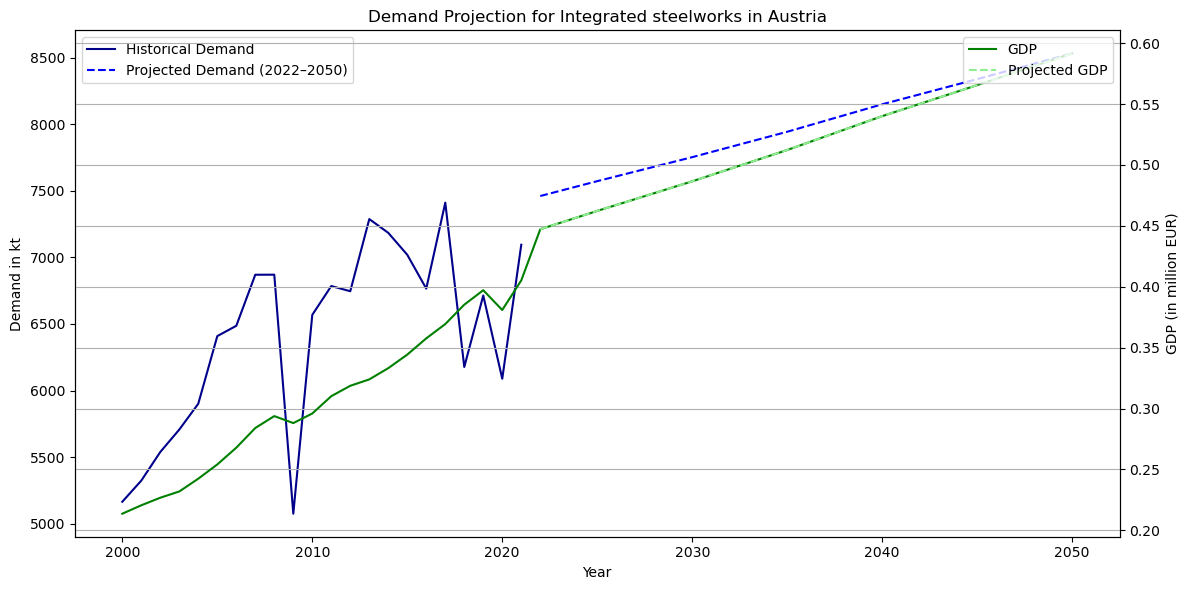

In [116]:
# Run linear regression for the Blast Furnace route in the steel sector
steel_bf_projection = linear_regression_single_sector(
    demand_df=steel_bf,                        # DataFrame containing historical demand for BF steel (kt)
    sector_name=steel_bf.columns[0],           # Sector name, taken from the first column
    historic_gdp=historic_gdp,                 # Historical GDP data for the region
    projected_gdp=projected_gdp,               # Future GDP data for extrapolation
    gdp=gdp,                                   # Full GDP series for plotting
    region=gdp_region,                         # Name of the target GDP region
    unit="kt",                                 # Unit for demand values (kilotonnes)
    plot=True,                                 # Enable plotting of demand vs. GDP
    save=False                                 # Don't save output to Excel (set True to export)
)


####  Calculation Steps and Modeling Logic

2. **Quantify hydrogen demand for the DRI-BF route based on specific energy consumption (SEC) and process assumptions from Neuwirth et al.**


In [117]:
# Constants for hydrogen demand conversion from Neuwirth et al. (2022)
SEC_H2 = 1.89       # Specific energy consumption: MWh per tonne of steel
LHV_H2 = 33.3       # Lower heating value of hydrogen: MWh per t_H2

# Calculate hydrogen demand in tonnes H2 per tonne of steel
H2_demand_t_per_t_steel = SEC_H2 / LHV_H2  # = 0.057 tH2 per t_steel

In [118]:
# Convert projected steel demand to total hydrogen demand (in tonnes)
# Note: Multiply by 1000 to convert kilotonnes (kt) to tonnes

steel_bf_projection["Total Technical H2 Demand [t]"] = steel_bf_projection["Predicted Demand"] * H2_demand_t_per_t_steel * 1000

####  Calculation Steps and Modeling Logic

3. **Simulate hydrogen adoption based on a stepwise integration aligned with European decarbonization targets.**

In [119]:
# Apply linear interpolation of target shares over time
# and multiply by the total hydrogen demand to get the realistically targeted H2 demand.
# This adds a new column "Demand in tH2" to the DataFrame.

steel_bf_projection = apply_linear_target(
    steel_bf_projection,         # DataFrame with projected total H₂ demand
    "Total Technical H2 Demand [t]",         # Column with full technical H₂ demand (kt → t conversion already done)
    "Phased H2 Demand [t]",             # New column to hold the scaled demand based on targets
    targets_steel_bf             # Dictionary of target shares by year (e.g., {2020: 0.0, 2030: 0.1, ...})
)


In [120]:
steel_bf_projection

,Predicted Demand,Total Technical H2 Demand [t],Phased H2 Demand [t]
Year,,,
2022-01-01,7461.643075,423498.661000,0.000000
2023-01-01,7498.889864,425612.667942,0.000000
2024-01-01,7536.136653,427726.674884,0.000000
2025-01-01,7573.383442,429840.681826,0.000000
2026-01-01,7609.461051,431888.329916,0.000000
2027-01-01,7645.538660,433935.978007,0.000000
2028-01-01,7681.616269,435983.626097,0.000000
2029-01-01,7717.693879,438031.274188,0.000000
2030-01-01,7753.771488,440078.922278,44007.892228


### Chemicals Sector

#### Calculation Steps and Modeling Logic

1. **Read in energy conversion factors** from Saygin et al. (2011) and Neuwirth et al. (2024).
2. **Estimate chemical production activity** until 2050 using JRC projections for basic chemicals.
3. **Calculate the shares of methanol, ammonia, and HVC** in basic chemical demand using plant-level production data from Neuwirth et al. (2024).
4. **Apply those shares** to disaggregate the JRC projections into product-specific demand.
5. **Convert demand units** from ethylene-equivalent to product-specific demand using energy-based conversion factors.

---

### Input Assumptions

- The JRC dataset provides overall projections for **basic chemical demand** in **kt ethylene equivalent**.
- Plant-level production estimates for **primary steel, methanol, ammonia, and ethylene** are sourced from **Neuwirth et al. (2024)**.
- To compare these products on a common energy basis, production values (in tonnes) are converted to **ethylene equivalents** using **Specific Energy Consumption (SEC)** values from **Saygin et al. (2011)**.

---

### Specific Energy Consumption (SEC) — GJ/tonne of output

| Country  | Methanol (SEC_MeOH) | Ammonia (SEC_NH3) | HVC (SEC_HVC) |
|----------|----------------------|--------------------|---------------|
| Benelux  | 10.0                 | 14.3               | 15.3          |
| France   | —                    | 16.5               | 15.4          |
| Germany  | 12.4                 | 16.6               | 15.7          |
| Italy    | —                    | 15.0               | 15.9          |
| **Average** | **11.2**          | **15.6**           | **15.575**    |

*SEC values indicate the energy requirement per tonne of chemical produced.*

---

### Energy-Based Conversion to Hydrogen-Relevant Units

Conversion to hydrogen-equivalent or methanol-equivalent is based on Neuwirth (2022), Appendix B.2 — Chemical Industry:

| Product   | Conversion Factor       | Unit        |
|-----------|--------------------------|-------------|
| Methanol  | 6.31                     | MWh per t H₂ |
| Ammonia   | 5.92                     | MWh per t H₂ |
| Ethylene  | 2.54                     | MWh per t MeOH |

These factors are used to estimate **hydrogen demand** for each product based on projected activity.

---


####  Calculation Steps and Modeling Logic

1. **Read in energy conversion factors** from Saygin et al. (2011) and Neuwirth et al. (2024).


In [121]:
# -------------------------------
# Specific Energy Consumption (SEC) for Chemical Production [in GJ/t] (Saygin et al.)
# -------------------------------

# Methanol (MeOH)
SEC_MeOH_Benelux = 10.0
SEC_MeOH_DE = 12.4
SEC_MeOH_Average = 11.2

# Ammonia (NH3)
SEC_NH3_Benelux = 14.3
SEC_NH3_FR = 16.5
SEC_NH3_DE = 16.6
SEC_NH3_IT = 15.0
SEC_NH3_Average = 15.6

# High-Value Chemicals (HVC)
SEC_HVC_Benelux = 15.3
SEC_HVC_FR = 15.4
SEC_HVC_DE = 15.7
SEC_HVC_IT = 15.9
SEC_HVC_Average = 15.575

# -------------------------------
# Convert SEC to GWh/t (1 GWh = 3600 GJ)
# -------------------------------

SEC_HVC_Benelux_GWh = SEC_HVC_Benelux / 3600
SEC_HVC_FR_GWh = SEC_HVC_FR / 3600
SEC_HVC_DE_GWh = SEC_HVC_DE / 3600
SEC_HVC_IT_GWh = SEC_HVC_IT / 3600
SEC_HVC_Average_GWh = SEC_HVC_Average / 3600  # ≈ 0.0043278 GWh/t



In [122]:
# ----------------------------------------------------------
# Conversion Ratios to Express Hydrogen Demand in HVC Equivalents
# ----------------------------------------------------------

# Ratio of average SEC for Methanol to HVC
# Interpreted as: 1 t of MeOH ≈ x t of HVC in energy terms
MeOH_to_HVC = SEC_MeOH_Average / SEC_HVC_Average  # ≈ 0.719

# Ratio of average SEC for Ammonia to HVC
NH3_to_HVC = SEC_NH3_Average / SEC_HVC_Average  # ≈ 1.0016

# ----------------------------------------------------------
# Demand Conversion Factor from HVC to Methanol
# ----------------------------------------------------------

# Indicates how many tonnes of Methanol are needed to produce 1 t of HVC-equivalent demand
# Often used in hydrogen substitution modeling
HVC_to_MeOH = 2.54




####  Calculation Steps and Modeling Logic

2. **Estimate chemical production activity** until 2050 using JRC projections for basic chemicals.


In [123]:
# Read in JRC data for the Chemical industry
chemicals = pd.read_excel(file_name, sheet_name="CHI")

# Build the full column name for filtering or referencing
chemicals_column_name = jrc_region + ": Chemical industry"

# Ensure all column names are strings (important for filtering)
chemicals.columns = chemicals.columns.astype(str)

# Drop unnamed (index or empty) columns and create a copy to avoid SettingWithCopyWarning
chemicals_cleaned = chemicals.loc[:, ~chemicals.columns.str.contains('^Unnamed:')].copy()

# Drop any rows with missing values
chemicals_cleaned.dropna(how='any', inplace=True)

# Reset the DataFrame index after dropping rows
chemicals_cleaned.reset_index(drop=True, inplace=True)


In [124]:
# Extract the fourth row (index 3) from the cleaned Chemical data as a new DataFrame
basic_chem = pd.DataFrame(chemicals_cleaned.iloc[3])

# Set column names using the first row of the extracted data (often units or labels)
basic_chem.columns = basic_chem.iloc[0]

# Drop metadata rows that are not actual year values
basic_chem.drop([chemicals_column_name, 'Code'], axis=0, inplace=True)

# Rename index to 'Year' and convert it to datetime format
basic_chem.index.name = 'Year'
basic_chem.index = pd.to_datetime(basic_chem.index, format='%Y', errors='coerce')


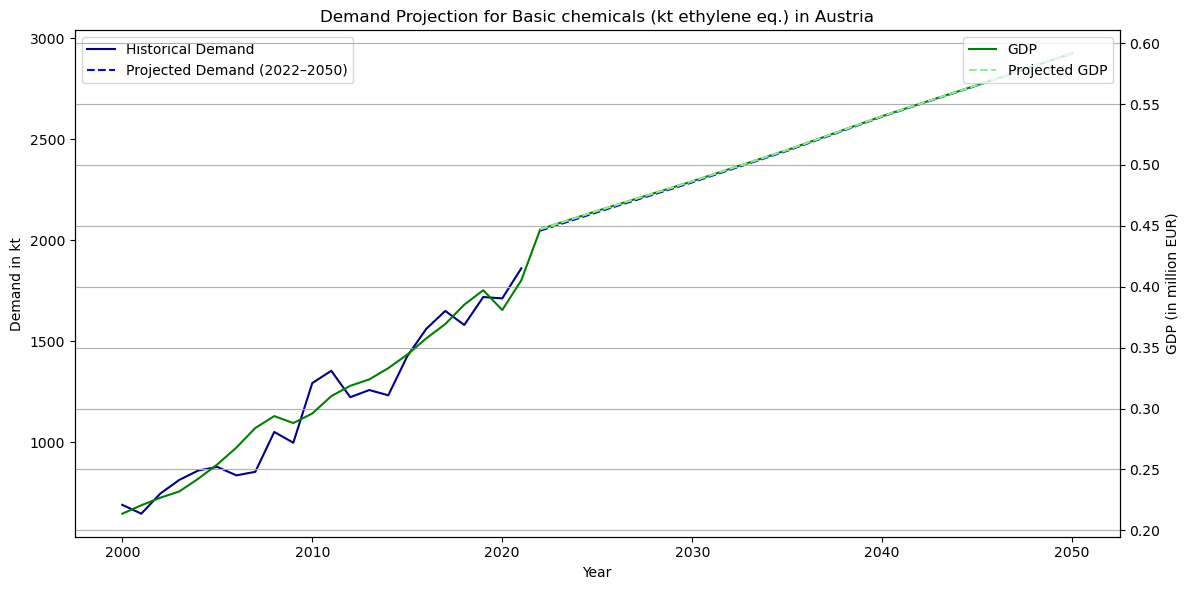

In [125]:
# Run linear regression for the basic chemicals sector to project demand until 2050
basic_chem_projection = linear_regression_single_sector(
    demand_df=basic_chem,                      # DataFrame with historical demand (kt)
    sector_name=basic_chem.columns[0],         # Use the first column name as the sector label
    historic_gdp=historic_gdp,                 # GDP data for training the model
    projected_gdp=projected_gdp,               # Future GDP data for prediction
    gdp=gdp,                                    # Full GDP data for plotting
    region=gdp_region,                         # GDP region name
    unit="kt",                                  # Unit of demand
    plot=True,                                  # Show plot with projections
    save=False                                  # Do not save to file (set to True if needed)
)


#### Detailed Step 3/4/5: Calculating Product Shares in Basic Chemical Demand

3. **Determine the shares of methanol, ammonia, and HVC** in overall basic chemical demand by using calibrated, plant-level production data from **Neuwirth et al. (2024)**. 

This allows for a more representative allocation of total chemical demand across product categories.

---

#### JRC Data on the Chemical Sector

![JRC Chemicals](JRC_Chemicals.png)

The **JRC (2022)** dataset provides a comprehensive projection of total chemical demand in Europe, expressed in **kt ethylene equivalent**. 

However, it includes a wide array of chemical products beyond the hydrogen-relevant ones considered here.

---

#### Comparison: Neuwirth (2024) vs. JRC (2022)

- **Neuwirth (2024)** estimates production of approximately **34,145 kt ethylene equivalent** for Europe (based on ammonia, methanol, and ethylene).

- **JRC (2022)** reports a broader estimate of **86,747 kt ethylene equivalent**, which includes additional chemical categories beyond the hydrogen-intensive ones.

Because of this discrepancy, a **scaling factor** is applied to align Neuwirth's hydrogen-relevant chemical coverage with the broader JRC projection. 

This factor represents the share of hydrogen-relevant chemicals in the current baseline (2021).

---

#### Converting Product Shares to Final Demand Estimates

Once this percentage share is derived, it is applied to the **JRC forward projections** (2022–2050) to isolate the demand evolution for hydrogen-relevant chemicals only. 

The shares for **methanol, ammonia, and HVC** are then used to split the JRC aggregate demand accordingly.

Finally, demand values expressed in **ethylene-equivalent kilotonnes (kt)** are converted into **product-specific units** (e.g., kt methanol or kt ammonia), using the energy-based conversion factors from **Saygin et al. (2011)** and **Neuwirth (2022)**.



In [126]:
# -------------------------------------------------------------
# Load Industrial Production Data from Neuwirth (2024) Excel
# -------------------------------------------------------------
neuwirth_path = os.path.join(inputs_dir, 'Industry_Data','Neuwirth_2024_Supplementary_Data', '02_Industrial_Site_Database.xlsx')
neuwirth_df = pd.read_excel(
    neuwirth_path,
    sheet_name="Database"
)
if jrc_region !="EU27":
    neuwirth_df = neuwirth_df.loc[neuwirth_df.Country == jrc_region]
    
# -------------------------------------------------------------
# Filter for calibrated production by product
# -------------------------------------------------------------
df_steel_primary = neuwirth_df.query("Product == 'Steel, primary'")
df_ethylene = neuwirth_df.query("Product == 'Ethylene'")
df_methanol = neuwirth_df.query("Product == 'Methanol'")
df_ammonia = neuwirth_df.query("Product == 'Ammonia'")

# -------------------------------------------------------------
# Compute total calibrated production per product [in tonnes]
# -------------------------------------------------------------
steel_primary_tons = df_steel_primary["Production in tons (calibrated)"].sum()
ethylene_tons = df_ethylene["Production in tons (calibrated)"].sum()
methanol_tons = df_methanol["Production in tons (calibrated)"].sum()
ammonia_tons = df_ammonia["Production in tons (calibrated)"].sum()


In [127]:
# -------------------------------------------------------------
# Convert methanol and ammonia production to ethylene-equivalent demand
# -------------------------------------------------------------

# Estimated demand for methanol and ammonia, expressed in ethylene-equivalent tonnes
methanol_demand_ethylene_eq_tons = methanol_tons * MeOH_to_HVC
ammonia_demand_ethylene_eq_tons  = ammonia_tons * NH3_to_HVC

# Total chemical demand in ethylene-equivalent terms [tonnes]
total_chemical_demand_ethylene_eq_tons = (
    ethylene_tons + methanol_demand_ethylene_eq_tons + ammonia_demand_ethylene_eq_tons
)

# Convert to kilotonnes [kt]
total_chemical_demand_ethylene_eq_kt = total_chemical_demand_ethylene_eq_tons / 1000

# -------------------------------------------------------------
# Calculate 2022 demand shares for methanol, ammonia, and ethylene
# -------------------------------------------------------------
baseline_2022_demand_kt = basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"].iloc[0]

share_methanol = (methanol_demand_ethylene_eq_tons / 1000) / baseline_2022_demand_kt
share_ammonia  = (ammonia_demand_ethylene_eq_tons / 1000)  / baseline_2022_demand_kt
share_ethylene = (ethylene_tons / 1000) / baseline_2022_demand_kt


####  Calculation Steps and Modeling Logic

4. **Apply those shares** to disaggregate the JRC projections into product-specific demand.


In [128]:
# -------------------------------------------------------------
# Apply calculated shares to disaggregate projected chemical demand
# -------------------------------------------------------------
basic_chem_projection["Methanol Demand [kt ethylene eq]"] = basic_chem_projection["Predicted Demand"] * share_methanol
basic_chem_projection["Ammonia Demand [kt ethylene eq]"]  = basic_chem_projection["Predicted Demand"] * share_ammonia
basic_chem_projection["Ethylene Demand [kt ethylene eq]"] = basic_chem_projection["Predicted Demand"] * share_ethylene



####  Calculation Steps and Modeling Logic

5. **Convert demand units** from ethylene-equivalent to product-specific demand using energy-based conversion factors.


In [129]:

# -------------------------------------------------------------
# 🔁 Convert ethylene-equivalent demand to material-specific units
# -------------------------------------------------------------
basic_chem_projection["Methanol Demand [kt MeOH]"] = basic_chem_projection["Methanol Demand [kt ethylene eq]"] / MeOH_to_HVC
basic_chem_projection["Ammonia Demand [kt NH3]"]   = basic_chem_projection["Ammonia Demand [kt ethylene eq]"] / NH3_to_HVC

# Convert HVC demand to methanol-equivalent via SEC and conversion factor
basic_chem_projection["High Value Chemicals Demand [kt MeOH]"] = basic_chem_projection["Ethylene Demand [kt ethylene eq]"] * SEC_HVC_Average_GWh * HVC_to_MeOH

In [130]:
basic_chem_projection

,Predicted Demand,Methanol Demand [kt ethylene eq],Ammonia Demand [kt ethylene eq],Ethylene Demand [kt ethylene eq],Methanol Demand [kt MeOH],Ammonia Demand [kt NH3],High Value Chemicals Demand [kt MeOH]
Year,,,,,,,
2022-01-01,2047.772977,0.0,420.674157,500.000000,0.0,420.000000,5.494514
2023-01-01,2078.252400,0.0,426.935547,507.442090,0.0,426.251356,5.576295
2024-01-01,2108.731822,0.0,433.196937,514.884180,0.0,432.502711,5.658077
2025-01-01,2139.211244,0.0,439.458327,522.326271,0.0,438.754067,5.739858
2026-01-01,2168.733915,0.0,445.523172,529.534753,0.0,444.809192,5.819072
2027-01-01,2198.256586,0.0,451.588016,536.743235,0.0,450.864318,5.898286
2028-01-01,2227.779257,0.0,457.652861,543.951718,0.0,456.919443,5.977501
2029-01-01,2257.301927,0.0,463.717705,551.160200,0.0,462.974568,6.056715
2030-01-01,2286.824598,0.0,469.782550,558.368682,0.0,469.029693,6.135929


### Validation by comparing Neuwirth and JRC data

In [131]:
# Get t_ethylene eq to compare
methanol_tons_ethylene_eq = methanol_tons*MeOH_to_HVC
ammonia_tons_ethylene_eq = ammonia_tons*NH3_to_HVC

In [132]:
# Sum of all basic chemical production
neuwirth_chems_sum = ethylene_tons + methanol_tons_ethylene_eq + ammonia_tons_ethylene_eq

# from t ethylene eq to kt ethylene eq
neuwirth_chems_sum/1000 

920.6741573033707

In [133]:
basic_chem_projection.query("Year == @pd.Timestamp('2022-01-01')")["Predicted Demand"]

Year
2022-01-01    2047.772977
Name: Predicted Demand, dtype: float64

#### Non Metallic Minerals - Cement, Ceramics and Glass production

### Step 1: Reading Sectoral Demand and Differentiating Sub-Sectors

The first step in the analysis is to read in the overall industrial demand for the non-metallic minerals sector.

Within this sector, we differentiate between the following key sub-sectors:

- **Cement production**
- **Ceramics production**
- **Glass production**

In [134]:
NMM_column_name = jrc_region+ ': Non-metallic mineral products / final energy consumption'

In [135]:
# Converting ktoe energy demand into GWh
ktoe_to_GWh = 11.63

In [136]:
NMM = pd.read_excel(file_name, sheet_name="NMM_fec")

# Build the full column name for filtering or referencing
NMM_column_name = jrc_region + ": Non-metallic mineral products / final energy consumption"

# Ensure all column names are strings
NMM.columns = NMM.columns.astype(str)

# Remove unnamed columns (typically empty index columns) and create a copy to avoid warnings
NMM_cleaned = NMM.loc[:, ~NMM.columns.str.contains('^Unnamed:')].copy()

# Drop rows with any missing values
NMM_cleaned.dropna(how='any', inplace=True)

# Reset index for cleaner structure
NMM_cleaned.reset_index(drop=True, inplace=True)


In [137]:
# Filter the subsectors out of the overall NMM

cement = NMM_cleaned.iloc[:(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0])]
ceramics = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0]):(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0])]
glass = NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0]):(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass: Finishing processes"].index[0]+1)]

###  Cement

In the cement sector, green fuel demand is considered only for preheating and clinker production, which are specifically disaggregated in the JRC dataset.

Currently, approximately 67% of energy demand in these processes is covered by alternative fuels, particularly various forms of waste.

However, the **Technology Readiness Levels (TRL)** of deeper decarbonization options remain low:
- **<3 for full electrification**
- **<4 for hydrogen-based heating systems**

Hybrid options are being discussed, but they also remain at low TRL levels. Therefore, a pragmatic modeling workaround is applied:

#### Workaround Approach

1. Target only fossil fuel substitution in the sub-processes of clinker production and preheating/pre-calcination — as disaggregated in the JRC data.
2. Assume waste-derived fuels continue to be part of the energy mix, and their share increases gradually.
3. Apply regression-based projections to estimate how the share of waste (biomass & waste fuels) evolves.
4. Assign the remaining energy demand to either green fuels (e.g., hydrogen, synthetic fuels) or electrification based on feasibility.

---

### Cement Sector: Calculation Steps and Modeling Logic

1. **Estimate cement production activity** until 2050 using JRC projections for the non-metallic minerals (NMM) sector.
2. **Filter energy demand for preheating and clinker production**, as these are the key stages for fuel substitution.  
   Remaining sub-processes (e.g., grinding and packaging) are assumed to be fully electrified.
3. **Calculate the shares of biomass, natural gas/biogas, and other fossil fuels** in each sub-process.
4. **Project the shares of biomass, natural gas/biogas, and other fossil fuels** until 2050
   using country-specific linear regression on historical energy use in each sub-process.

5. **Apply the projected fuel shares** to the cement demand forecast to estimate absolute demand by fuel type and convert units. 
6. **Simulate green fuel  adoption** based on a stepwise integration aligned with European decarbonization targets.



### Cement Sector: Calculation Steps and Modeling Logic

1. **Estimate cement production activity** until 2050 using JRC projections for the non-metallic minerals (NMM) sector.

In [138]:
# Extract the cement data from the cleaned NMM data as a new DataFrame
cement_ktoe = pd.DataFrame(NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Cement"].index[0])])

# Set column names using the first row of the extracted data (often units or labels)
cement_ktoe.columns = cement_ktoe.iloc[0]

# Drop metadata rows that are not actual year values
cement_ktoe.drop([NMM_column_name, 'Code'], axis=0, inplace=True)

# Rename index to 'Year' and convert it to datetime format
cement_ktoe.index.name = 'Year'
cement_ktoe.index = pd.to_datetime(cement_ktoe.index, format='%Y', errors='coerce')


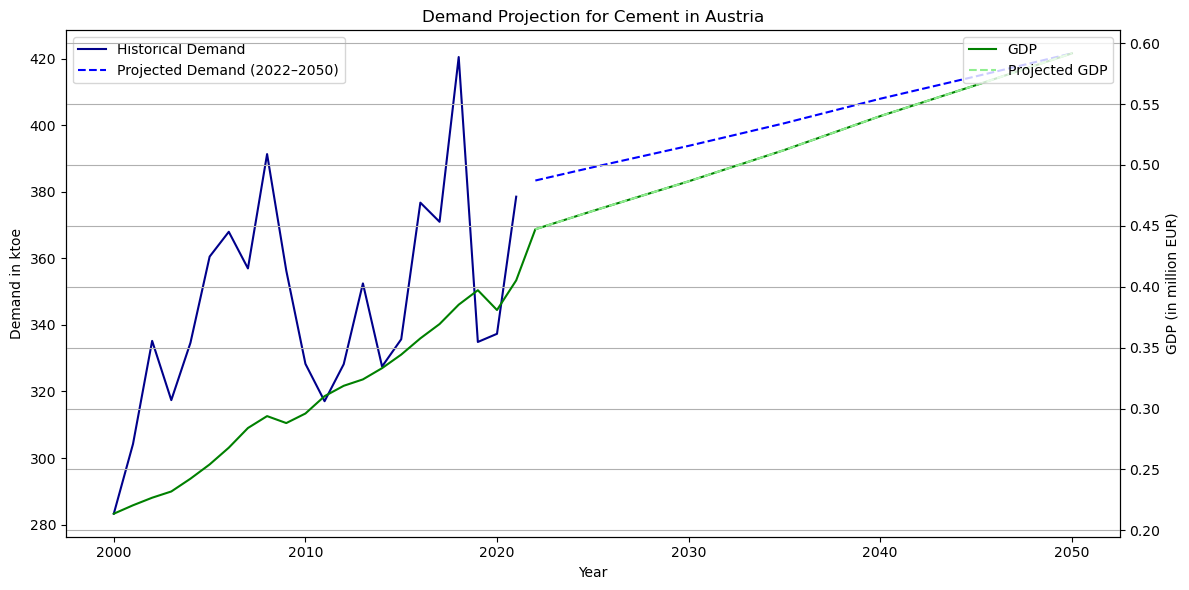

In [139]:
cement_projection = linear_regression_single_sector(
    demand_df=cement_ktoe,                      # Historical cement demand in ktoe
    sector_name=cement_ktoe.columns[0],         # Use the column name as sector label (e.g. "Cement")
    historic_gdp=historic_gdp,                  # Historical GDP data
    projected_gdp=projected_gdp,                # Projected GDP (future years)
    gdp=gdp,                                     # Combined GDP data for plotting
    region=gdp_region,                          # Name of GDP region
    unit="ktoe",                                 # Unit for demand data (kilotonnes of oil equivalent)
    plot=True,                                   # Show demand projection plot
    save=False                                   # Do not save results to Excel
)


### Cement Sector: Calculation Steps and Modeling Logic

2. **Filter energy demand for preheating and clinker production**, as these are the key stages for fuel substitution.  
   Remaining sub-processes (e.g., grinding and packaging) are assumed to be fully electrified.

In [140]:
# Filter the Energy demand out of the overall NMM - the rest of the demand is electrified

cement_preheating = cement.iloc[(cement[cement[NMM_column_name] == "Cement: Pre-heating and pre-calcination"].index[0]):(cement[cement[NMM_column_name] == "Cement: Clinker production (kilns)"].index[0])]
cement_clinker = cement.iloc[(cement[cement[NMM_column_name] == "Cement: Clinker production (kilns)"].index[0]):(cement[cement[NMM_column_name] == "Cement: Grinding, packaging and precasting (electricity)"].index[0])]


cement_clinker = transpose_uniformly(cement_clinker)
cement_preheating = transpose_uniformly(cement_preheating)

### Cement Sector: Calculation Steps and Modeling Logic

3. **Calculate the shares of biomass, natural gas/biogas, and other fossil fuels** in each sub-process.

In [141]:
# Biomass and Waste Share
# Combines biomass and waste usage from both preheating and clinker stages
cement_ktoe["Biomass and Waste Share"] = (
    cement_preheating["Biomass and waste"] + cement_clinker["Biomass and waste"]
) / cement_ktoe["Cement"]

# Natural Gas and Biogas Share
cement_ktoe["NG/Biogas Share"] = (
    cement_preheating["Natural gas and biogas"] + cement_clinker["Natural gas and biogas"]
) / cement_ktoe["Cement"]

# Remainder Fossil Fuel Share (LPG, Diesel Oil and Liquid biofuels, Fuel Oil, Other Liquids)
# This assumes the remainder is total minus biomass/waste and NG/Biogas for each stage
cement_ktoe["Other Fossil Fuel Share"] = (
    (cement_preheating["Cement: Pre-heating and pre-calcination"] - cement_preheating["Biomass and waste"]- cement_preheating["Natural gas and biogas"]) +
    (cement_clinker["Cement: Clinker production (kilns)"] - cement_clinker["Biomass and waste"] - cement_clinker["Natural gas and biogas"])
) / cement_ktoe["Cement"]


In [142]:
# Unit conversion from GWh to ktoe

cement_projection.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
cement_projection["Predicted Demand [GWh]"] = cement_projection["Predicted Demand [ktoe]"]*ktoe_to_GWh

In [143]:
# Replace NaN with 0 to ensure clean input for projecting the shares
cement_ktoe = cement_ktoe.fillna(0)

C:\Users\mar.eco\AppData\Local\Temp\ipykernel_23100\1199057387.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cement_ktoe = cement_ktoe.fillna(0)


### Cement Sector: Calculation Steps and Modeling Logic

4. **Project the shares of biomass, natural gas/biogas, and other fossil fuels** until 2050
   using country-specific linear regression on historical energy use in each sub-process.

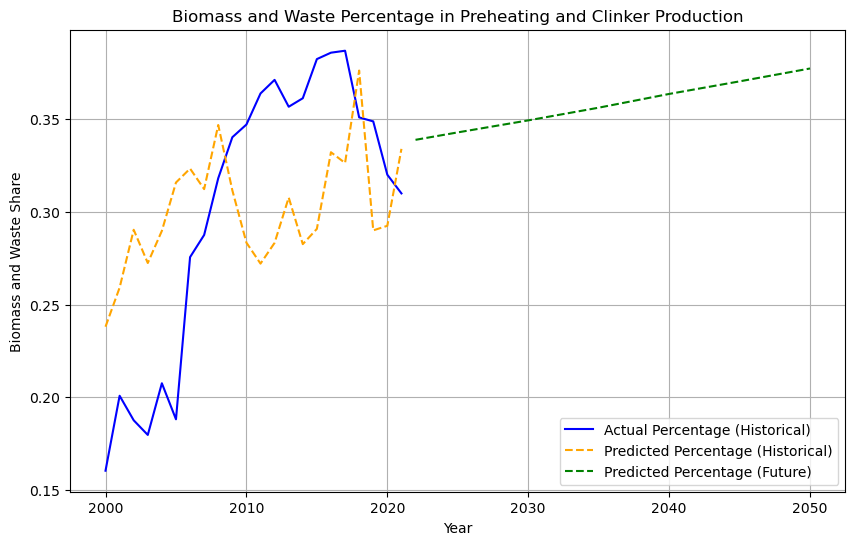

In [144]:
# -------------------------------------------------------------
# Project biomass and waste fuel share using linear regression
# -------------------------------------------------------------

cement_projection_biomass_percentage = linear_regression_share_prediction(
    demand_sector_df=cement_ktoe,                                                   # Historical cement sector data with fuel shares
    future_data_df=cement_projection,                                               # Future cement demand projections (e.g., 2022–2050)
    column_name_LR="Biomass and Waste Share",                                       # Dependent variable: historical fuel share to be projected
    column_name_IV="Cement",                                                        # Independent variable: historical total cement energy (ktoe)
    column_name_IV_future="Predicted Demand [ktoe]",                                # Independent variable for future data
    graph_title="Biomass and Waste Percentage in Preheating and Clinker Production",  # Plot title
    save=False                                                                      # Don't save to file (set to True if needed)
)


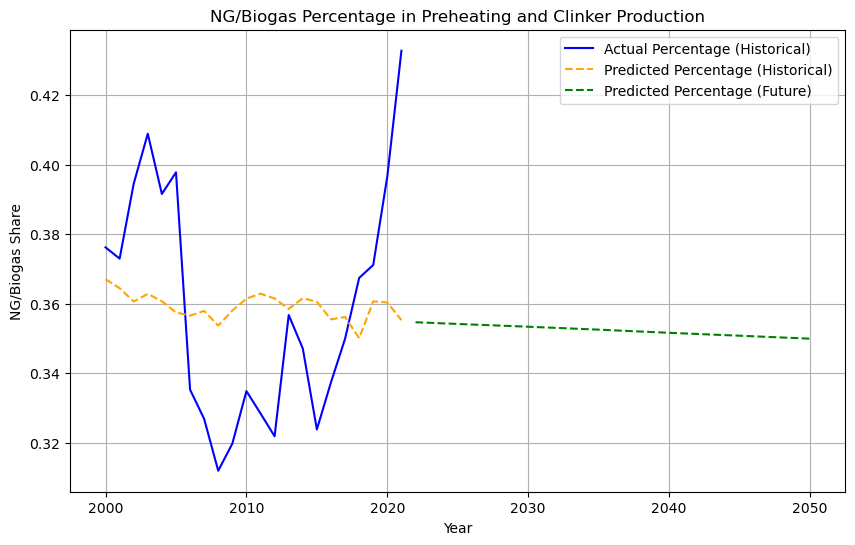

In [145]:
# -------------------------------------------------------------
# Project NG/Biogas fuel share using linear regression
# -------------------------------------------------------------

cement_projection_NG_percentage = linear_regression_share_prediction(
    demand_sector_df=cement_ktoe,                                                   # Historical cement sector data with fuel shares
    future_data_df=cement_projection,                                               # Future cement demand projections (e.g., 2022–2050)
    column_name_LR="NG/Biogas Share",                                               # Dependent variable: historical fuel share to be projected
    column_name_IV="Cement",                                                        # Independent variable: historical total cement energy (ktoe)
    column_name_IV_future="Predicted Demand [ktoe]",                                # Independent variable for future data
    graph_title="NG/Biogas Percentage in Preheating and Clinker Production",        # Plot title
    save=False                                                                      # Don't save to file (set to True if needed)
)


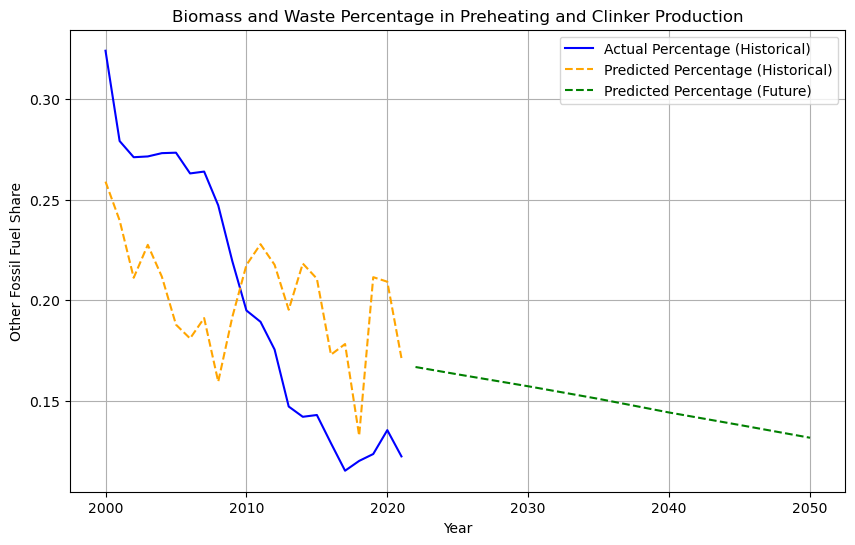

In [146]:
# -------------------------------------------------------------
# Project other fossil fuel share using linear regression
# -------------------------------------------------------------

cement_projection_other_fossil_percentage = linear_regression_share_prediction(
    demand_sector_df=cement_ktoe,                                                   # Historical cement sector data with fuel shares
    future_data_df=cement_projection,                                               # Future cement demand projections (e.g., 2022–2050)
    column_name_LR="Other Fossil Fuel Share",                                       # Dependent variable: historical fuel share to be projected
    column_name_IV="Cement",                                                        # Independent variable: historical total cement energy (ktoe)
    column_name_IV_future="Predicted Demand [ktoe]",                                # Independent variable for future data
    graph_title="Biomass and Waste Percentage in Preheating and Clinker Production",  # Plot title
    save=False                                                                      # Don't save to file (set to True if needed)
)


In [147]:
# Rename predicted percentage columns for clarity
cement_projection_biomass_percentage.rename(columns={'Predicted Percentage': 'Predicted Biomass Percentage'}, inplace=True)
cement_projection_NG_percentage.rename(columns={'Predicted Percentage': 'Predicted NG/Biogas Percentage'}, inplace=True)
cement_projection_other_fossil_percentage.rename(columns={'Predicted Percentage': 'Predicted Remainder Percentage'}, inplace=True)

### Cement Sector: Calculation Steps and Modeling Logic

5. **Apply the projected fuel shares** to the cement demand forecast to estimate absolute demand by fuel type and convert the units. 


In [148]:
# Calculate projected energy demand per fuel type (in GWh)
cement_projection["Predicted Biomass Demand [GWh]"] = cement_projection["Predicted Demand [GWh]"]*cement_projection_biomass_percentage["Predicted Biomass Percentage"]
cement_projection["Predicted NG/Biogas Demand [GWh]"] = cement_projection["Predicted Demand [GWh]"]*cement_projection_NG_percentage["Predicted NG/Biogas Percentage"]
cement_projection["Predicted Remainder Demand [GWh]"] = cement_projection["Predicted Demand [GWh]"]*cement_projection_other_fossil_percentage["Predicted Remainder Percentage"]


### Cement Sector: Calculation Steps and Modeling Logic

6. **Simulate green fuel  adoption** based on a stepwise integration aligned with European decarbonization targets.

In [149]:
# Apply linear ramp-up of NG fuels to substitute remainder fossil demand

cement_projection = apply_linear_target(
    demand_df=cement_projection,                            # DataFrame containing fuel-specific demand
    column_name_all="Predicted NG/Biogas Demand [GWh]",     # Full remainder fossil fuel demand
    column_name_after="Biogas demand [GWh]",           # Column to store green fuel substitution
    targets=targets_cement                                  # Dictionary with year:share targets (e.g., {2030: 0.1, 2040: 0.5, 2050: 1.0})
)

In [150]:
# Apply linear ramp-up of green fuels to substitute remainder fossil demand

cement_projection = apply_linear_target(
    demand_df=cement_projection,                            # DataFrame containing fuel-specific demand
    column_name_all="Predicted Remainder Demand [GWh]",     # Full remainder fossil fuel demand
    column_name_after="Green Fuel demand [GWh]",           # Column to store green fuel substitution
    targets=targets_cement                                  # Dictionary with year:share targets (e.g., {2030: 0.1, 2040: 0.5, 2050: 1.0})
)

In [151]:
cement_projection

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted Biomass Demand [GWh],Predicted NG/Biogas Demand [GWh],Predicted Remainder Demand [GWh],Biogas demand [GWh],Green Fuel demand [GWh]
Year,,,,,,,
2022-01-01,383.402436,4458.970333,1510.770273,1581.412232,744.054863,0.000000,0.000000
2023-01-01,384.730101,4474.411073,1521.980129,1586.152871,741.161469,0.000000,0.000000
2024-01-01,386.057765,4489.851813,1533.231246,1590.888433,738.230322,0.000000,0.000000
2025-01-01,387.385430,4505.292552,1544.523623,1595.618919,735.261423,0.000000,0.000000
2026-01-01,388.671419,4520.248606,1555.500870,1600.196074,732.349725,0.000000,0.000000
2027-01-01,389.957408,4535.204659,1566.516829,1604.768466,729.402607,0.000000,0.000000
2028-01-01,391.243397,4550.160713,1577.571499,1609.336095,726.420069,0.000000,0.000000
2029-01-01,392.529387,4565.116766,1588.664880,1613.898962,723.402112,0.000000,0.000000
2030-01-01,393.815376,4580.072820,1599.796972,1618.457065,720.348735,161.845707,72.034874


### Ceramics

Decarbonization in the ceramics sector is technologically challenging due to process temperature requirements and infrastructure limitations:

- Switching from natural gas to electric heating requires a complete redesign of kilns and comes with high investment costs. The technology is currently at TRL < 4.
- Switching from natural gas to hydrogen is technically feasible within existing plant designs but lacks industrial-scale deployment. The TRL is < 5.

#### Workaround Approach

1. Substitute fossil fuels in thermal processes, primarily sintering and drying.
2. Assume green fuels (e.g., SNG, hydrogen, or e-fuels) as the replacement vector for fossil fuel demand.
3. In thermal drying and sintering, the majority of fossil fuel demand is assumed to be covered by green fuel substitution.
4. In primary production, the biomass share is projected to increase based on regression analysis of historical data.

---

### Ceramics Sector: Calculation Steps and Modeling Logic

1. **Estimate ceramics production activity** until 2050 using JRC projections for the non-metallic minerals (NMM) sector.
2. **Filter energy demand** for sintering and primary production, which are the key thermal processes suitable for fuel switching.  
   The remaining steps (e.g., forming, grinding, packaging) are assumed to be **electrified**.
3. **Calculate the historical shares** of biomass, natural gas/biogas, and other fossil fuels by sub-process.
4. **Project those fuel shares** until 2050 using **country-specific linear regression** based on historical fuel use data.
5. **Apply the projected shares** to future ceramics demand and **convert to absolute energy demand** (e.g., GWh).
6. **Simulate the adoption of green fuels** using a stepwise increase in line with European decarbonization targets.


### Ceramics Sector: Calculation Steps and Modeling Logic

1. **Estimate ceramics production activity** until 2050 using JRC projections for the non-metallic minerals (NMM) sector.

In [152]:
# Extract the ceramics from the cleaned NMM data as a new DataFrame
ceramics_ktoe = pd.DataFrame(NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Ceramics & other NMM"].index[0])])

# Set column names using the first row of the extracted data (often units or labels)
ceramics_ktoe.columns = ceramics_ktoe.iloc[0]

# Drop metadata rows that are not actual year values
ceramics_ktoe.drop([NMM_column_name, 'Code'], axis=0, inplace=True)

# Rename index to 'Year' and convert it to datetime format
ceramics_ktoe.index.name = 'Year'
ceramics_ktoe.index = pd.to_datetime(ceramics_ktoe.index, format='%Y', errors='coerce')


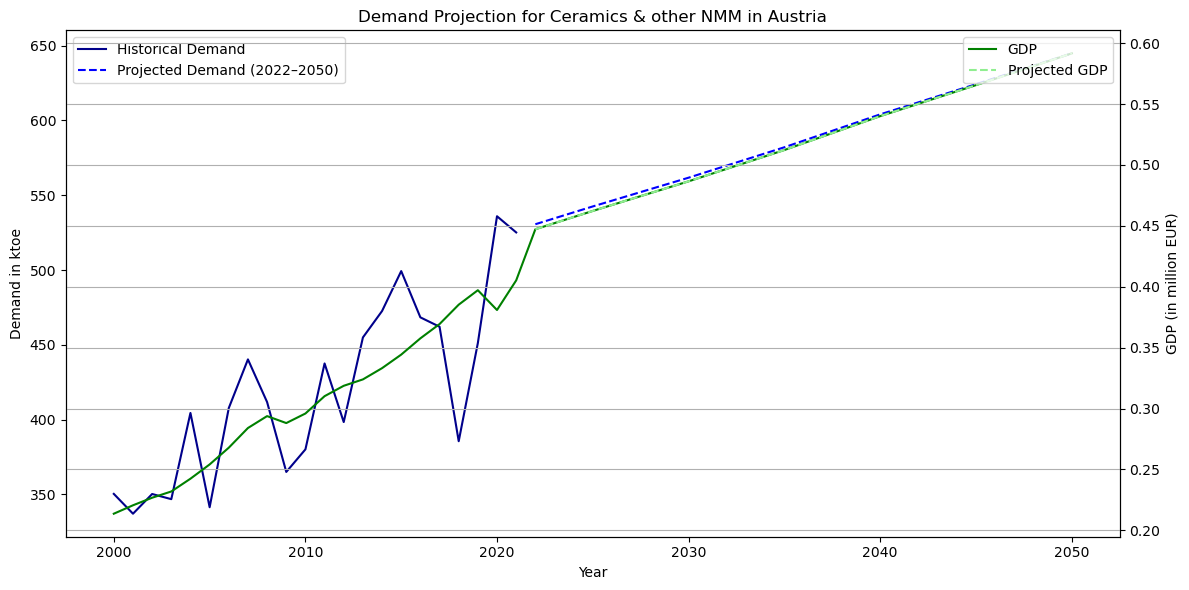

In [153]:
ceramics_projection = linear_regression_single_sector(
    demand_df=ceramics_ktoe,                      # Historical cement demand in ktoe
    sector_name=ceramics_ktoe.columns[0],         # Use the column name as sector label (e.g. "Cement")
    historic_gdp=historic_gdp,                    # Historical GDP data
    projected_gdp=projected_gdp,                  # Projected GDP (future years)
    gdp=gdp,                                      # Combined GDP data for plotting
    region=gdp_region,                            # Name of GDP region
    unit="ktoe",                                  # Unit for demand data (kilotonnes of oil equivalent)
    plot=True,                                    # Show demand projection plot
    save=False                                    # Do not save results to Excel
)


### Ceramics Sector: Calculation Steps and Modeling Logic

2. **Filter energy demand** for sintering and primary production, which are the key thermal processes suitable for fuel switching.  
   The remaining steps (e.g., forming, grinding, packaging) are assumed to be **electrified**.

In [154]:
# Extract sub-processes from the Ceramics dataset
ceramics_sintering = ceramics.loc[(ceramics[ceramics[NMM_column_name] == "Ceramics: Thermal drying and sintering"].index[0]):(ceramics[ceramics[NMM_column_name] == "Ceramics: Microwave drying and sintering"].index[0]-1)]
ceramics_production = ceramics.loc[(ceramics[ceramics[NMM_column_name] == "Ceramics: Thermal kiln"].index[0]):(ceramics[ceramics[NMM_column_name] == "Ceramics: Electric kiln"].index[0])]

ceramics_sintering = transpose_uniformly(ceramics_sintering)
ceramics_production = transpose_uniformly(ceramics_production)

In [155]:
# Combine related sintering and production subprocesses
ceramics_sintering["Ceramics: Drying and sintering of raw material"] = ceramics_sintering["Ceramics: Thermal drying and sintering"]+ceramics_sintering["Ceramics: Steam drying and sintering"]
ceramics_production["Ceramics: Primary production process"] = ceramics_production["Ceramics: Thermal kiln"]+ceramics_production["Ceramics: Electric kiln"]

### Ceramics Sector: Calculation Steps and Modeling Logic

3. **Calculate the historical shares** of sintering, biomass, natural gas/biogas, and other fossil fuels by sub-process.

In [156]:
# -------------------------------------------------------------
# Calculate key energy shares for ceramics sector
# -------------------------------------------------------------

# Share NG/Bioass for sintering relative to total ceramics demand
ceramics_ktoe["Share of NG/Biogas in Sintering"] = (
    (ceramics_sintering.loc[:, ceramics_sintering.columns == "Natural gas and biogas"].sum(axis=1))/ ceramics_ktoe["Ceramics & other NMM"]
)
# Share of remainnung fossil fiels used for sintering relative to total ceramics demand
ceramics_ktoe["Other Fossil Fuel Share in Sintering"] = (
    (ceramics_sintering["Ceramics: Drying and sintering of raw material"]- (ceramics_sintering.loc[:, ceramics_sintering.columns == "Natural gas and biogas"].sum(axis=1)) )
    / ceramics_ktoe["Ceramics & other NMM"]
)

# Share of NG/biogas used in primary production relative to total ceramics demand
ceramics_ktoe["Share of NG/Biogas in Primary Production"] = (
    ceramics_production["Natural gas and biogas"] / ceramics_ktoe["Ceramics & other NMM"]
)

# Share of biomass used in primary production relative to total ceramics demand
ceramics_ktoe["Share of Biomass in Primary Production"] = (
    ceramics_production["Biomass and waste"] / ceramics_ktoe["Ceramics & other NMM"]
)

# Share of remaining fossil fuels in thermal kilns (Solids, LNG, Diesel oil and liwuid biofuels, Fuel oil, Other liquid)
ceramics_ktoe["Other Fossil Fuel Share in Primary Production"] = (
    (ceramics_production["Ceramics: Thermal kiln"]
     - ceramics_production["Natural gas and biogas"]
     - ceramics_production["Biomass and waste"]) / ceramics_ktoe["Ceramics & other NMM"]
)


In [157]:
# Unit conversion from GWh to ktoe

ceramics_projection.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
ceramics_projection["Predicted Demand [GWh]"] = ceramics_projection["Predicted Demand [ktoe]"]*ktoe_to_GWh

In [158]:
# Replace NaN with 0 to ensure clean input for projecting the shares
ceramics_ktoe = ceramics_ktoe.fillna(0)

C:\Users\mar.eco\AppData\Local\Temp\ipykernel_23100\290271132.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ceramics_ktoe = ceramics_ktoe.fillna(0)


### Ceramics Sector: Calculation Steps and Modeling Logic

4. **Project those fuel shares** until 2050 using **country-specific linear regression** based on historical fuel use data.

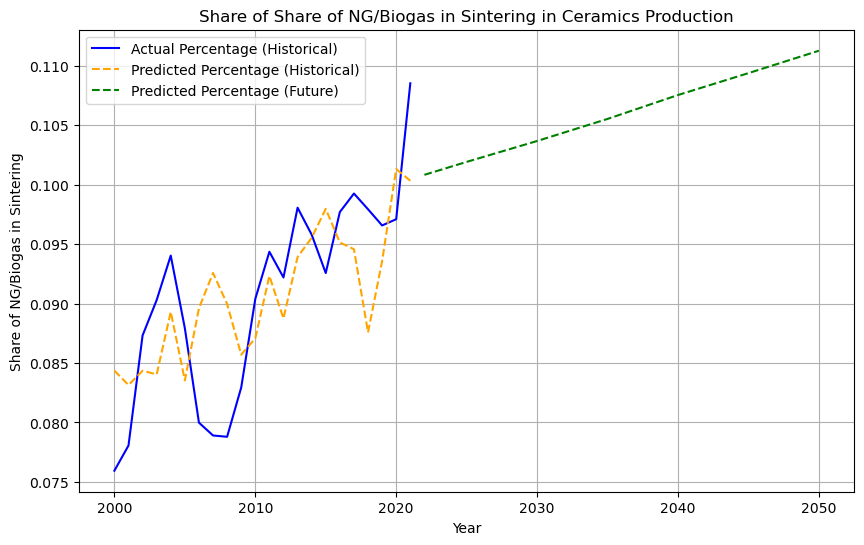

In [159]:
# -------------------------------------------------------------
# Project the future share of NG/Biogas in sintering in ceramics production
# -------------------------------------------------------------

ceramics_projection_NG_sintering_percentage = linear_regression_share_prediction(
    demand_sector_df=ceramics_ktoe,                             # Historical data (incl. share of sintering)
    future_data_df=ceramics_projection,                         # Projected total ceramics demand (ktoe or GWh)
    column_name_LR="Share of NG/Biogas in Sintering",          # Column to be predicted (dependent variable)
    column_name_IV="Ceramics & other NMM",                      # Independent variable for regression (historical demand)
    column_name_IV_future="Predicted Demand [ktoe]",            # Independent variable for prediction (future demand)
    graph_title="Share of Share of NG/Biogas in Sintering in Ceramics Production",    # Title for plot
    save=False                                                  # Save
)

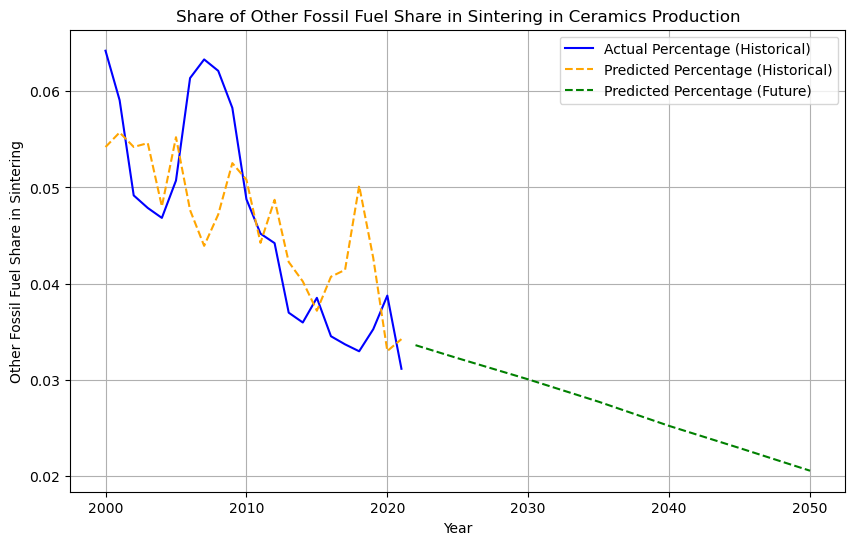

In [160]:
# -------------------------------------------------------------
# Project the future share of sintering in ceramics production
# -------------------------------------------------------------

ceramics_projection_remainder_sintering_percentage = linear_regression_share_prediction(
    demand_sector_df=ceramics_ktoe,                             # Historical data (incl. share of sintering)
    future_data_df=ceramics_projection,                         # Projected total ceramics demand (ktoe or GWh)
    column_name_LR="Other Fossil Fuel Share in Sintering",      # Column to be predicted (dependent variable)
    column_name_IV="Ceramics & other NMM",                      # Independent variable for regression (historical demand)
    column_name_IV_future="Predicted Demand [ktoe]",            # Independent variable for prediction (future demand)
    graph_title="Share of Other Fossil Fuel Share in Sintering in Ceramics Production",    # Title for plot
    save=False                                                  # Save
)

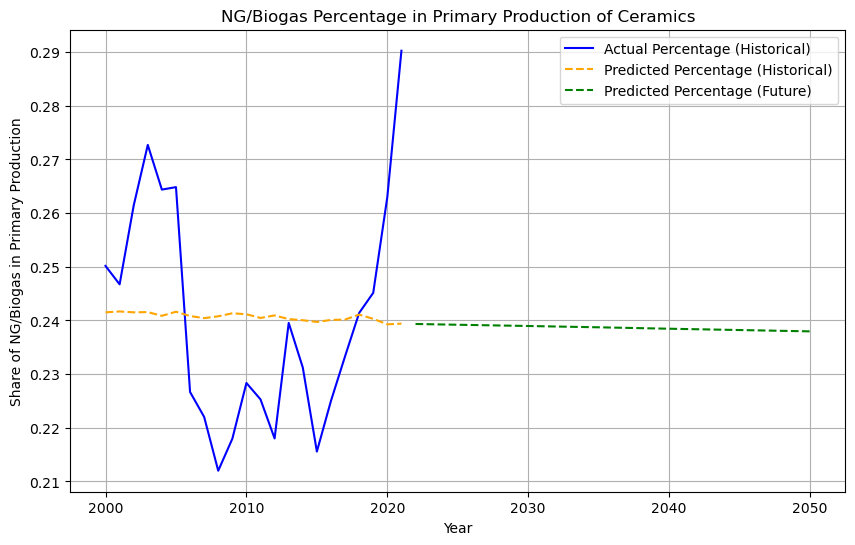

In [161]:
# -------------------------------------------------------------
# Project share of natural gas and biogas in ceramics production
# -------------------------------------------------------------

ceramics_projection_NG_biogas_percentage = linear_regression_share_prediction(
    demand_sector_df=ceramics_ktoe,                                         # Historical ceramics energy demand data
    future_data_df=ceramics_projection,                                     # Future projected ceramics demand (ktoe)
    column_name_LR="Share of NG/Biogas in Primary Production",              # Column to project
    column_name_IV="Ceramics & other NMM",                                  # Historical independent variable (demand)
    column_name_IV_future="Predicted Demand [ktoe]",                        # Future independent variable
    graph_title="NG/Biogas Percentage in Primary Production of Ceramics",   # Plot title
    save=False                                                              # Save
)

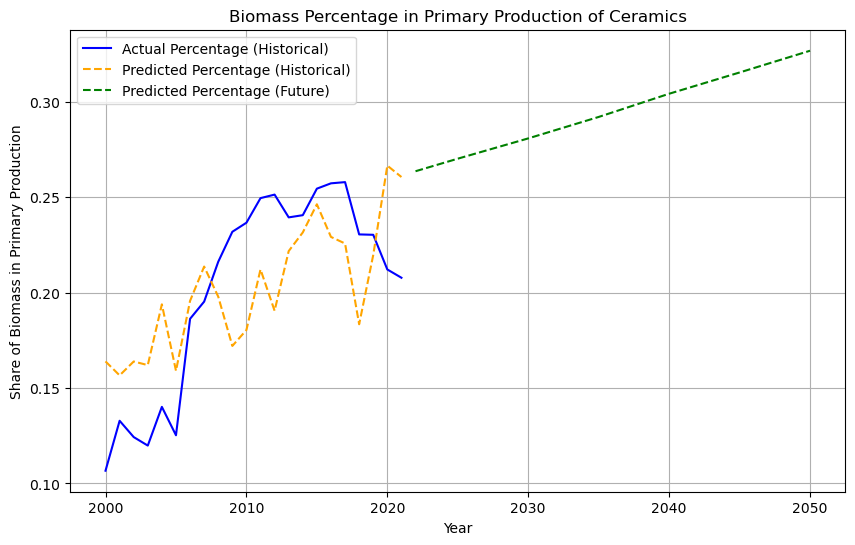

In [162]:
# -------------------------------------------------------------
# Project share of biomass in primary ceramics production
# -------------------------------------------------------------

ceramics_projection_biomass_percentage = linear_regression_share_prediction(
    demand_sector_df=ceramics_ktoe,             # Historical ceramics energy data (incl. fuel shares)
    future_data_df=ceramics_projection,                         # Future projected ceramics demand (ktoe)
    column_name_LR="Share of Biomass in Primary Production",  # Target column for regression
    column_name_IV="Ceramics & other NMM",                                  # Independent variable (historical demand)
    column_name_IV_future="Predicted Demand [ktoe]",            # Future demand input
    graph_title="Biomass Percentage in Primary Production of Ceramics",  # Title for plot
    save=False                                                  # Do not export to file
)

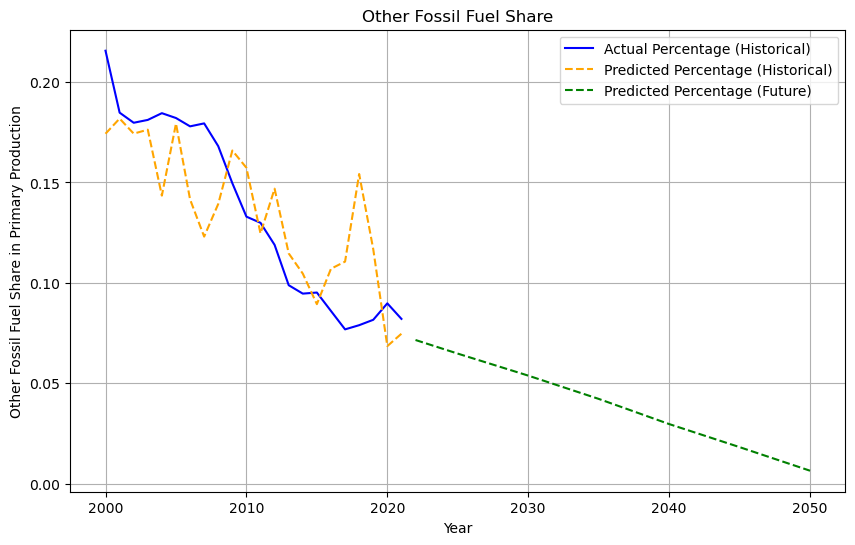

In [163]:
# -------------------------------------------------------------
# Project remainder fuel share (non-biomass, non-NG/biogas) 
# in primary ceramics production
# -------------------------------------------------------------

ceramics_projection_remainder_percentage = linear_regression_share_prediction(
    demand_sector_df=ceramics_ktoe,                                     # Historical data with energy shares
    future_data_df=ceramics_projection,                                 # Projected ceramics demand (ktoe)
    column_name_LR="Other Fossil Fuel Share in Primary Production",     # Column to be predicted
    column_name_IV="Ceramics & other NMM",                              # Historical demand for regression
    column_name_IV_future="Predicted Demand [ktoe]",                    # Future demand to predict from
    graph_title="Other Fossil Fuel Share",                              # Title for plot
    save=False                                                          # Skip file export
)


### Ceramics Sector: Calculation Steps and Modeling Logic

5. **Apply the projected shares** to future ceramics demand and **convert to absolute energy demand** (e.g., GWh).

In [164]:
# Rename predicted percentage columns for clarity
ceramics_projection_NG_sintering_percentage.rename(columns={'Predicted Percentage': 'Predicted NG/Biogas Sintering Percentage'}, inplace=True)
ceramics_projection_remainder_sintering_percentage.rename(columns={'Predicted Percentage': 'Predicted Remainder Sintering Percentage'}, inplace=True)
ceramics_projection_NG_biogas_percentage.rename(columns={'Predicted Percentage': 'Predicted NG/Biogas Percentage'}, inplace=True)
ceramics_projection_biomass_percentage.rename(columns={'Predicted Percentage': 'Predicted Biomass Percentage'}, inplace=True)
ceramics_projection_remainder_percentage.rename(columns={'Predicted Percentage': 'Predicted Remainder Percentage'}, inplace=True)


In [165]:
# Natural gas  in sintering 
ceramics_projection["Predicted NG/Biogass Demand in Sintering Demand [GWh]"] = (
    ceramics_projection["Predicted Demand [GWh]"] *
    ceramics_projection_NG_sintering_percentage['Predicted NG/Biogas Sintering Percentage']
)

# Remainder fossil fuels in sintering
ceramics_projection["Predicted Remainder Demand in Sintering Demand [GWh]"] = (
    ceramics_projection["Predicted Demand [GWh]"] *
    ceramics_projection_remainder_sintering_percentage['Predicted Remainder Sintering Percentage']
)

# Natural gas or hydrogen demand in primary production
ceramics_projection["Predicted NG/Biogas Demand in Primary Production [GWh]"] = (
    ceramics_projection["Predicted Demand [GWh]"] *
    ceramics_projection_NG_biogas_percentage["Predicted NG/Biogas Percentage"]
)

# Biomass demand in primary production
ceramics_projection["Predicted Biomass Demand in Primary Production [GWh]"] = (
    ceramics_projection["Predicted Demand [GWh]"] *
    ceramics_projection_biomass_percentage["Predicted Biomass Percentage"]
)

# Remainder fossil fuels (e.g., oil-based) in thermal processes
ceramics_projection["Predicted Remainder Demand in Primary Production [GWh]"] = (
    ceramics_projection["Predicted Demand [GWh]"] *
    ceramics_projection_remainder_percentage["Predicted Remainder Percentage"]
)


### Ceramics Sector: Calculation Steps and Modeling Logic

6. **Simulate green fuel  adoption** based on a stepwise integration aligned with European decarbonization targets.

In [166]:
# -------------------------------------------------------------
# Apply green fuel ramp-up for NG/H2 and remainder fuel demand
# -------------------------------------------------------------

# Replace a growing share of NG/Biogas in sintering demand with synthetic/green alternatives
ceramics_projection = apply_linear_target(
    demand_df=ceramics_projection,
    column_name_all="Predicted NG/Biogass Demand in Sintering Demand [GWh]",           # Fossil-based baseline
    column_name_after="Sintering: NG/Biogas fuel demand [GWh]",               # Output: share taken by H₂ or SNG
    targets=targets_ceramics                                              # e.g., {2030: 0.2, 2040: 0.6, 2050: 1.0}
)

# Replace a growing share of sintering demand with synthetic/green alternatives
ceramics_projection = apply_linear_target(
    demand_df=ceramics_projection,
    column_name_all="Predicted Remainder Demand in Sintering Demand [GWh]",           # Fossil-based baseline
    column_name_after="Sintering: Green fuel demand [GWh]",               # Output: share taken by H₂ or SNG
    targets=targets_ceramics                                              # e.g., {2030: 0.2, 2040: 0.6, 2050: 1.0}
)


# Replace a growing share of NG/H2 demand with synthetic/green alternatives
ceramics_projection = apply_linear_target(
    demand_df=ceramics_projection,
    column_name_all="Predicted NG/Biogas Demand in Primary Production [GWh]",           # Fossil-based baseline
    column_name_after="Primary Production: NG/Biogas demand [GWh]",                  # Output: share taken by H₂ or SNG
    targets=targets_ceramics                                   # e.g., {2030: 0.2, 2040: 0.6, 2050: 1.0}
)

# Replace remainder fossil fuels with advanced green fuels (e.g., bio-oil, e-fuels)
ceramics_projection = apply_linear_target(
    demand_df=ceramics_projection,
    column_name_all="Predicted Remainder Demand in Primary Production [GWh]",
    column_name_after="Primary Production: Green fuel demand [GWh]",
    targets=targets_ceramics
)


### Glass Sector

Glass production involves two distinct melting processes, each with specific decarbonization challenges and technology readiness:

#### Process 1: Container Glass (U-shaped flame tray)
- Share of total energy use in Germany: 33–34%
- Electrification is technically feasible for small plants (TRL 9), but remains < TRL 4 for large-scale applications.
- Hydrogen-fired burners are still at TRL < 4.

#### Process 2: Continuous Melting (Flat Glass)
- Share of total energy use in Germany: 42–45%
- Electrification has a TRL < 3
- Hydrogen-fired burners remain at TRL < 4

#### Workaround Assumption
Based on technical feasibility, it is assumed that 44% of the thermal melting demand will not be electrifiable, and will therefore require hydrogen-based fuels starting from 2040 onward.

---

### Glass Sector: Calculation Steps and Modeling Logic

1. **Estimate glass production activity** until 2050 using JRC projections for the non-metallic minerals (NMM) sector.
2. **Filter energy demand** for the **melting process**, which is the primary candidate for fuel substitution.  
   Remaining sub-processes (e.g., forming, annealing, grinding, packaging) are assumed to be fully **electrified**.
3. **Calculate the historical fuel shares** used in melting and related thermal processes from historical JRC data.
4. **Project fuel shares forward to 2050** using **country-specific linear regression** models.
5. **Determine the non-electrifiable portion** of the melting demand — assumed to be **44%** based on technical limitations.
6. **Apply projected fuel shares** to the overall demand forecast and **convert to absolute energy values** (e.g., GWh).
7. **Simulate green fuel adoption** by assigning the non-electrifiable share to **hydrogen or e-fuels**, particularly beginning **after 2040**.



### Glass Sector: Calculation Steps and Modeling Logic

1. **Estimate glass production activity** until 2050 using JRC projections for the non-metallic minerals (NMM) sector.


In [167]:
# Extract the ceramics from the cleaned NMM data as a new DataFrame
glass_ktoe = pd.DataFrame(NMM_cleaned.iloc[(NMM_cleaned[NMM_cleaned[NMM_column_name] == "Glass production"].index[0])])

# Set column names using the first row of the extracted data (often units or labels)
glass_ktoe.columns = glass_ktoe.iloc[0]

# Drop metadata rows that are not actual year values
glass_ktoe.drop([NMM_column_name, 'Code'], axis=0, inplace=True)

# Rename index to 'Year' and convert it to datetime format
glass_ktoe.index.name = 'Year'
glass_ktoe.index = pd.to_datetime(glass_ktoe.index, format='%Y', errors='coerce')

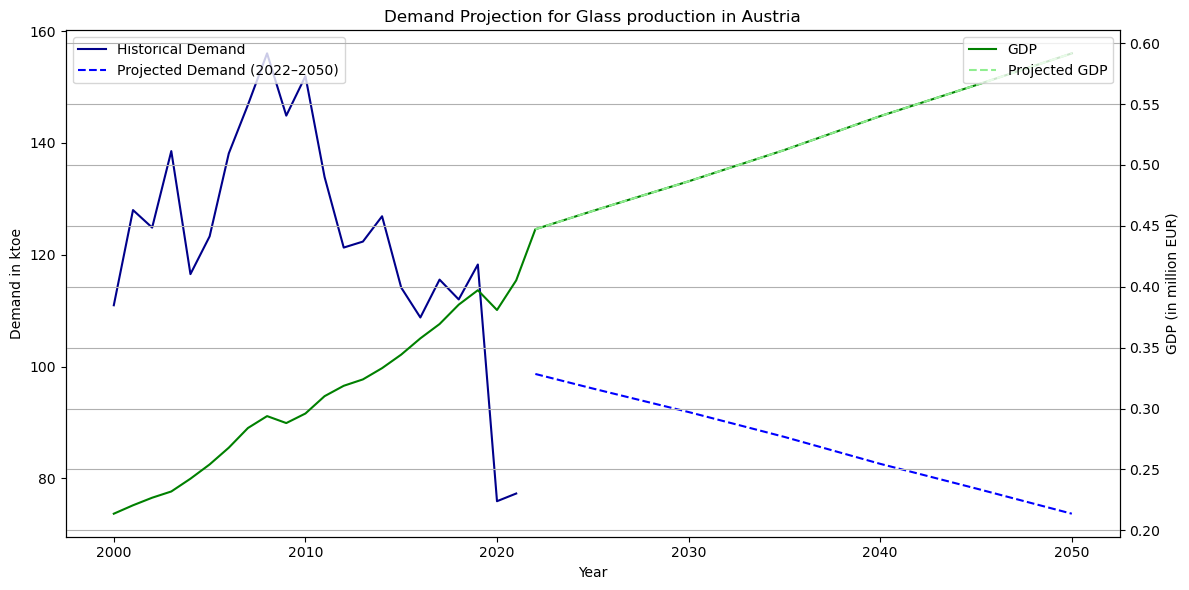

In [168]:
glass_projection = linear_regression_single_sector(
    demand_df=glass_ktoe,                      # Historical cement demand in ktoe
    sector_name=glass_ktoe.columns[0],         # Use the column name as sector label (e.g. "Cement")
    historic_gdp=historic_gdp,                    # Historical GDP data
    projected_gdp=projected_gdp,                  # Projected GDP (future years)
    gdp=gdp,                                      # Combined GDP data for plotting
    region=gdp_region,                            # Name of GDP region
    unit="ktoe",                                  # Unit for demand data (kilotonnes of oil equivalent)
    plot=True,                                    # Show demand projection plot
    save=False                                    # Do not save results to Excel
)


### Glass Sector: Calculation Steps and Modeling Logic

2. **Filter energy demand** for the **melting process**, which is the primary candidate for fuel substitution.  
   Remaining sub-processes (e.g., forming, annealing, grinding, packaging) are assumed to be fully **electrified**.

In [169]:
# Extract sub-processes from the Glass dataset
glass_thermal_melting = glass.loc[(glass[glass[NMM_column_name] == "Glass: Thermal melting tank"].index[0]):(glass[glass[NMM_column_name] == "Glass: Electric melting tank"].index[0]-1)]

glass_thermal_melting = transpose_uniformly(glass_thermal_melting)

### Glass Sector: Calculation Steps and Modeling Logic

3. **Calculate the historical fuel shares** used in melting and related thermal processes from historical JRC data.

In [170]:
# -------------------------------------------------------------
# Calculate share of thermal melting in total glass energy demand
# -------------------------------------------------------------

glass_ktoe["Share of Thermal Melting"] = (
    glass_thermal_melting["Glass: Thermal melting tank"] /
    glass_ktoe["Glass production"]
)

In [171]:
# Unit conversion from GWh to ktoe
glass_projection.rename(columns={'Predicted Demand': 'Predicted Demand [ktoe]'}, inplace=True)
glass_projection["Predicted Demand [GWh]"] = glass_projection["Predicted Demand [ktoe]"]*ktoe_to_GWh

In [172]:
# Replace NaN with 0 to ensure clean input for projecting the shares
glass_ktoe = glass_ktoe.fillna(0)

C:\Users\mar.eco\AppData\Local\Temp\ipykernel_23100\663394495.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  glass_ktoe = glass_ktoe.fillna(0)


### Glass Sector: Calculation Steps and Modeling Logic

4. **Project fuel shares forward to 2050** using **country-specific linear regression** models.

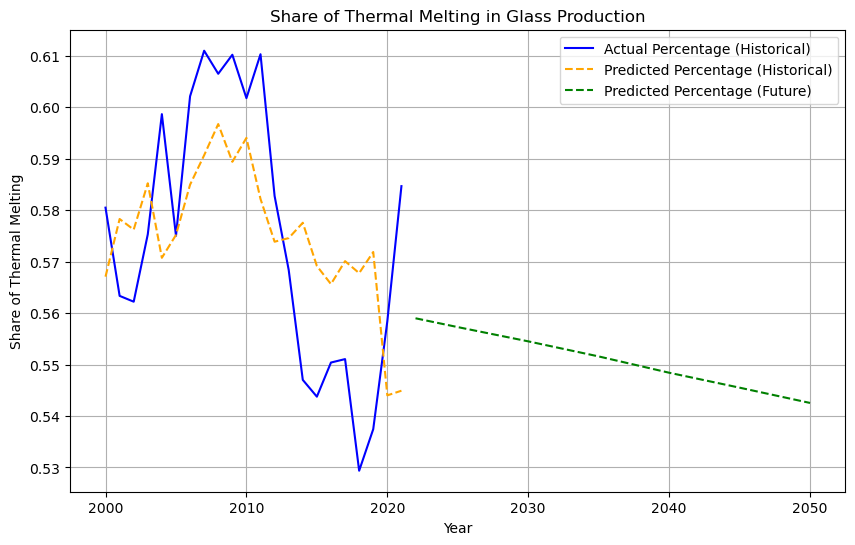

In [173]:
# -------------------------------------------------------------
# Project the share of thermal melting in total glass demand
# -------------------------------------------------------------

glass_projection_thermal_melting_percentage = linear_regression_share_prediction(
    demand_sector_df=glass_ktoe,             # Historical data with thermal melting share
    future_data_df=glass_projection,                         # Future total glass demand projections
    column_name_LR="Share of Thermal Melting",               # Column to predict
    column_name_IV="Glass production",                                  # Historical independent variable
    column_name_IV_future="Predicted Demand [ktoe]",         # Future independent variable
    graph_title="Share of Thermal Melting in Glass Production",  # Plot title
    save=False                                                # Do not export to file
)


In [174]:
# Rename predicted percentage columns for clarity
glass_projection_thermal_melting_percentage.rename(columns={'Predicted Percentage': 'Predicted Thermal Melting Percentage'}, inplace=True)


### Glass Sector: Calculation Steps and Modeling Logic

7. **Simulate green fuel adoption** by assigning the non-electrifiable share to **hydrogen or e-fuels**, particularly beginning **after 2040**.

In [175]:
share_non_eletrifiable = 0.44

In [176]:
glass_projection["Predicted NG/H2 Demand [GWh]"] = glass_projection["Predicted Demand [GWh]"]*glass_projection_thermal_melting_percentage["Predicted Thermal Melting Percentage"]*share_non_eletrifiable


### Glass Sector: Calculation Steps and Modeling Logic

7. **Simulate green fuel adoption** by assigning the non-electrifiable share to **hydrogen or e-fuels**, particularly beginning **after 2040**.

In [177]:
# -------------------------------------------------------------
# Apply green fuel ramp-up to NG/H₂ demand in glass melting
# -------------------------------------------------------------
glass_projection = apply_linear_target(
    demand_df=glass_projection,                          # Future demand DataFrame
    column_name_all="Predicted NG/H2 Demand [GWh]",      # Total fossil-based demand to decarbonize
    column_name_after="NG/Biogas demand [GWh]",            # Output column for green substitution
    targets=targets_glass                                # e.g., {2030: 0.2, 2040: 0.5, 2050: 1.0}
)


In [178]:
glass_projection

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted NG/H2 Demand [GWh],NG/Biogas demand [GWh]
Year,,,,
2022-01-01,98.693578,1147.806314,282.306418,0.000000
2023-01-01,97.825353,1137.708857,279.536717,0.000000
2024-01-01,96.957128,1127.611401,276.772096,0.000000
2025-01-01,96.088903,1117.513945,274.012556,0.000000
2026-01-01,95.247932,1107.733448,271.344481,0.000000
2027-01-01,94.406961,1097.952952,268.681173,0.000000
2028-01-01,93.565989,1088.172456,266.022630,0.000000
2029-01-01,92.725018,1078.391959,263.368855,0.000000
2030-01-01,91.884047,1068.611463,260.719845,26.071984


In [179]:
# Conversion factors
H2_to_GWh = 0.0333        # 1 tH2 = 0.0333 GWh
ktMeOH_to_GWh = 5.53      # 1 kt MeOH = 5.53 GWh
ktNH3_to_GWh = 5.17       # 1 kt NH3 = 5.17 GWh

In [180]:
demand_2030 = pd.DataFrame(columns=["Iron & steel", "Chemicals","Non-metallic minerals"], index=["Overall Demand", "Hydrogen", "Methanol", "Ammonia", "Biomass","Biogas" , "Other"] )
demand_2040 = pd.DataFrame(columns=["Iron & steel", "Chemicals","Non-metallic minerals"], index=["Overall Demand", "Hydrogen", "Methanol", "Ammonia", "Biomass", "Biogas", "Other"])
demand_2050 = pd.DataFrame(columns=["Iron & steel", "Chemicals","Non-metallic minerals"], index=["Overall Demand", "Hydrogen", "Methanol", "Ammonia", "Biomass", "Biogas" , "Other"])


#### Exporting Sectoral Fuel Demand by Year
The data is prepared and exported a summary of hydrogen and alternative fuel demand across industrial sectors (iron & steel, chemicals, non-metallic minerals) for the years 2030, 2040, and 2050.

The function prep_saving() pulls fuel demand from individual sector projections and writes the values into a unified summary DataFrame. The final outputs are saved as Excel files for each target year, broken down by fuel and sector.


In [181]:
# -------------------------------------------------------------
# 📋 Define function to prepare fuel demand summary for a given year
# -------------------------------------------------------------
def prep_saving(df, year): 
    # Create datetime object and string representation for lookup
    date = datetime.datetime(year=year, month=1, day=1)
    date_str = date.strftime("%Y-%m-%d")

    # Iron & Steel sector: Convert hydrogen demand (tH2 → GWh)
    df.loc["Hydrogen", "Iron & steel"] = (
        steel_bf_projection.loc[date_str, "Phased H2 Demand [t]"] * H2_to_GWh
    )

    # Chemicals sector: Convert ammonia demand (kt → GWh)
    df.loc["Ammonia", "Chemicals"] = (
        basic_chem_projection.loc[date_str, "Ammonia Demand [kt NH3]"] * ktNH3_to_GWh
    )

    # Chemicals sector: Combine MeOH and HVC demand (kt → GWh)
    df.loc["Methanol", "Chemicals"] = (
        basic_chem_projection.loc[date_str, "Methanol Demand [kt MeOH]"] +
        basic_chem_projection.loc[date_str, "High Value Chemicals Demand [kt MeOH]"]
    ) * ktMeOH_to_GWh

    # Non-metallic minerals: Sum biogas demand across sub-sectors
    df.loc["Biogas", "Non-metallic minerals"] = (
        cement_projection.loc[date_str, "Biogas demand [GWh]"] +
        ceramics_projection.loc[date_str, "Sintering: NG/Biogas fuel demand [GWh]"] +
        ceramics_projection.loc[date_str, "Primary Production: NG/Biogas demand [GWh]"] +
        glass_projection.loc[date_str, "NG/Biogas demand [GWh]"]
    )

    # Non-metallic minerals: Biomass demand from cement and ceramics
    df.loc["Biomass", "Non-metallic minerals"] = (
        cement_projection.loc[date_str, "Predicted Biomass Demand [GWh]"] +
        ceramics_projection.loc[date_str, "Predicted Biomass Demand in Primary Production [GWh]"]
    )

    # Non-metallic minerals: Green fuels (e.g., hydrogen, e-fuels)
    df.loc["Other", "Non-metallic minerals"] = (
        cement_projection.loc[date_str, "Green Fuel demand [GWh]"] +
        ceramics_projection.loc[date_str, "Sintering: Green fuel demand [GWh]"] +
        ceramics_projection.loc[date_str, "Primary Production: Green fuel demand [GWh]"]
    )

    return df




In [182]:
ceramics_projection

,Predicted Demand [ktoe],Predicted Demand [GWh],Predicted NG/Biogass Demand in Sintering Demand [GWh],Predicted Remainder Demand in Sintering Demand [GWh],Predicted NG/Biogas Demand in Primary Production [GWh],Predicted Biomass Demand in Primary Production [GWh],Predicted Remainder Demand in Primary Production [GWh],Sintering: NG/Biogas fuel demand [GWh],Sintering: Green fuel demand [GWh],Primary Production: NG/Biogas demand [GWh],Primary Production: Green fuel demand [GWh]
Year,,,,,,,,,,,
2022-01-01,530.631519,6171.244569,622.201423,207.370754,1477.021559,1627.161664,441.746014,0.000000,0.000000,0.000000,0.000000
2023-01-01,534.601467,6217.415058,629.110105,206.102216,1487.774638,1652.982551,430.998623,0.000000,0.000000,0.000000,0.000000
2024-01-01,538.571414,6263.585546,636.052258,204.791795,1498.523301,1679.006127,420.042527,0.000000,0.000000,0.000000,0.000000
2025-01-01,542.541362,6309.756035,643.027883,203.439491,1509.267548,1705.232390,408.877726,0.000000,0.000000,0.000000,0.000000
2026-01-01,546.386692,6354.477228,649.816454,202.089706,1519.670322,1730.828653,397.864408,0.000000,0.000000,0.000000,0.000000
2027-01-01,550.232022,6399.198421,656.636427,200.700626,1530.068953,1756.615079,386.655281,0.000000,0.000000,0.000000,0.000000
2028-01-01,554.077353,6443.919615,663.487804,199.272252,1540.463441,1782.591667,375.250347,0.000000,0.000000,0.000000,0.000000
2029-01-01,557.922683,6488.640808,670.370583,197.804583,1550.853786,1808.758419,363.649604,0.000000,0.000000,0.000000,0.000000
2030-01-01,561.768014,6533.362001,677.284765,196.297620,1561.239987,1835.115333,351.853053,67.728476,19.629762,156.123999,35.185305


In [183]:
# Demand for the respective years
demand_2030 = prep_saving(demand_2030, 2030)
demand_2040 = prep_saving(demand_2040, 2040)
demand_2050 = prep_saving(demand_2050, 2050)

In [184]:
# Save results
if save_final_result == True: 
    output_path = os.path.join('Results_per_Country')
    demand_2030.to_excel(os.path.join(output_path, f"2030_{jrc_region}.xlsx"))
    demand_2040.to_excel(os.path.join(output_path, f"2040_{jrc_region}.xlsx"))
    demand_2050.to_excel(os.path.join(output_path, f"2050_{jrc_region}.xlsx"))